In [1]:
%load_ext autoreload
%autoreload 2

import os
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u
from scipy.fft import fftshift
from cmocean.cm import thermal
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase
from spectres import spectres

import lifesim
from inlifesim.spectra import create_pink_psd, rms_frequency_adjust
from inlifesim.util import temp2freq_fft
from lifesim.util.radiation import black_body
import inlifesim as ils

# 1. Setup parameters and load spectrum

In [2]:
path_spectrum = '/Users/fdannert/Documents/projects/InLIFEsim/working/nice_requirements/input_data/Earth_PRTunits_10pc.txt'
path_bs = '/Users/fdannert/Documents/projects/InLIFEsim/working/paper/final_result_table/lookup_table_1e10_Nov24.pkl'

In [4]:
earth_twin = {'distance_s': 10,
              'temp_s': 5778.,
              'radius_s': 1.,
              'lat_s': 0.78,
              'l_sun': 1.,
              'z': 1.,
              'temp_p': 254.,
              'radius_p': 1.,
              'sep_p': 1.,}

dbw = {'ap_diameter': 3.,
       'spec_res': 50.,
       't_int': 16 * 24 * 60 * 60,  #  10 * 24 * 60 * 60
       'throughput': 0.035,
       't_exp': 60 * 10,
       'n_rot': 1,
       'wl_bin': 10e-6,  # 10e-6
       'bl': 14.5,
       'ratio': 6,
       'wl_bin_width': 0.3e-6,  # 0.3e-6
       'rms_mode': 'wavelength',
       'hyperrot_noise': 'zero',
       'd_phi_rms': 0.0013,  # 0.005, 0.001
       'd_a_rms': 0.0013,
       'd_x_rms': 0.,
       'd_y_rms': 0.,
       'd_pol_rms': 0.0013,
       'd_a_co': 10e3,
       'd_phi_co': 10e3,
       'd_pol_co': 10e3,
       'd_x_co': 0.64e-3,
       'd_y_co': 0.64e-3}

dbw_rat2 = deepcopy(dbw)
dbw_rat2['ratio'] = 2

In [6]:
data = pd.read_csv(
    path_spectrum,
    header=None, sep='\s+')

lam_PRT = data[0].values * u.micron
f_PRT = data[1].values * u.erg / u.cm ** 2 / u.s / u.Hz
f_lifesim = f_PRT.to(u.photon / u.m ** 2 / u.s / u.micron,
                     equivalencies=u.spectral_density(lam_PRT))

f_lifesim = f_lifesim.to(u.photon / u.s / u.meter ** 3)
lam_lifesim = lam_PRT.to(u.meter)

# scale planet flux to distance
f_lifesim *= (10 / earth_twin['distance_s']) ** 2

flux_planet_spectrum = [lam_lifesim, f_lifesim]
f_lifesim = spectres(new_wavs=np.array((dbw['wl_bin'] - dbw['wl_bin_width'] / 2, dbw['wl_bin'] + dbw['wl_bin_width'] / 2)),
                     spec_wavs=lam_lifesim.value,
                     spec_fluxes=f_lifesim.value,
                     edge_mode=True)
flux_planet_spectrum = f_lifesim * dbw['wl_bin_width']

In [7]:
# calculate bin widths from bin positions lam_lifesim
bin_widths = np.append(np.diff(lam_lifesim.value), 0)

flux_planet_spectrum_bb = black_body(mode='planet',
                                     # bins=lam_lifesim.value,
                                     # width=bin_widths,
                                     bins=np.array((dbw['wl_bin'], )),
                                     width=np.array((dbw['wl_bin_width'], )),
                                     temp=254,
                                     radius=earth_twin['radius_p'],
                                     distance=earth_twin['distance_s'],)

# flux_planet_spectrum_bb /= dbw['wl_bin_width']
flux_planet_spectrum = flux_planet_spectrum_bb

# 2. Run instrument model
To get the template function for ratio 6 and ratio 2 case.

In [8]:
col_pos = np.array((
                (-dbw['bl'] / 2,
                 -dbw['bl'] * dbw['ratio'] / 2),
                (-dbw['bl'] / 2,
                 dbw['bl'] * dbw['ratio'] / 2),
                (dbw['bl'] / 2,
                 -dbw['bl'] * dbw['ratio'] / 2),
                (dbw['bl'] / 2,
                 dbw['bl'] * dbw['ratio'] / 2)
            ))

instrument = ils.Instrument(wl_bins=np.array((dbw['wl_bin'], )),
                            wl_bin_widths=np.array((dbw['wl_bin_width'], )),
                            image_size=512,
                            diameter_ap=dbw['ap_diameter'],
                            flux_division=np.array((0.25, 0.25, 0.25, 0.25)),
                            throughput=dbw['throughput'],
                            dist_star=earth_twin['distance_s'],
                            radius_star=earth_twin['radius_s'],
                            temp_star=earth_twin['temp_s'],
                            lat_star=earth_twin['lat_s'],
                            l_sun=earth_twin['l_sun'],
                            z=earth_twin['z'],
                            temp_planet=earth_twin['temp_p'],
                            radius_planet=earth_twin['radius_p'],
                            separation_planet=earth_twin['sep_p'],
                            col_pos=col_pos,
                            phase_response=np.array((0, np.pi / 2, np.pi, 3 * np.pi / 2)),
                            phase_response_chop=-np.array((0, np.pi / 2, np.pi, 3 * np.pi / 2)),
                            n_rot=dbw['n_rot'],
                            t_total=dbw['t_int'],
                            t_exp=dbw['t_exp'],
                            n_cpu=1,
                            rms_mode=dbw['rms_mode'],
                            hyperrot_noise=dbw['hyperrot_noise'],
                            n_sampling_max=int(1e7),
                            d_a_rms=dbw['d_a_rms'],
                            d_phi_rms=dbw['d_phi_rms'],
                            d_pol_rms=dbw['d_pol_rms'],
                            d_x_rms=dbw['d_x_rms'],
                            d_y_rms=dbw['d_y_rms'],
                            d_a_co=dbw['d_a_co'],
                            d_phi_co=dbw['d_phi_co'],
                            d_pol_co=dbw['d_pol_co'],
                            d_x_co=dbw['d_x_co'],
                            d_y_co=dbw['d_y_co'],
                            n_draws=None,
                            n_draws_per_run=None,
                            time_series_return_values='all',
                            flux_planet=flux_planet_spectrum,
                            simultaneous_chopping=True,
                            verbose=True,
                            draw_samples=False,
                            get_single_bracewell=False,
                            instrumental_source=None)
instrument.run()

ils_res = deepcopy(instrument.photon_rates_chop)

col_pos = np.array((
                (-dbw_rat2['bl'] / 2,
                 -dbw_rat2['bl'] * dbw_rat2['ratio'] / 2),
                (-dbw_rat2['bl'] / 2,
                 dbw_rat2['bl'] * dbw_rat2['ratio'] / 2),
                (dbw_rat2['bl'] / 2,
                 -dbw_rat2['bl'] * dbw_rat2['ratio'] / 2),
                (dbw_rat2['bl'] / 2,
                 dbw_rat2['bl'] * dbw_rat2['ratio'] / 2)
            ))

instrument_rat2 = ils.Instrument(wl_bins=np.array((dbw_rat2['wl_bin'], )),
                            wl_bin_widths=np.array((dbw_rat2['wl_bin_width'], )),
                            image_size=512,
                            diameter_ap=dbw_rat2['ap_diameter'],
                            flux_division=np.array((0.25, 0.25, 0.25, 0.25)),
                            throughput=dbw_rat2['throughput'],
                            dist_star=earth_twin['distance_s'],
                            radius_star=earth_twin['radius_s'],
                            temp_star=earth_twin['temp_s'],
                            lat_star=earth_twin['lat_s'],
                            l_sun=earth_twin['l_sun'],
                            z=earth_twin['z'],
                            temp_planet=earth_twin['temp_p'],
                            radius_planet=earth_twin['radius_p'],
                            separation_planet=earth_twin['sep_p'],
                            col_pos=col_pos,
                            phase_response=np.array((0, np.pi / 2, np.pi, 3 * np.pi / 2)),
                            phase_response_chop=-np.array((0, np.pi / 2, np.pi, 3 * np.pi / 2)),
                            n_rot=dbw_rat2['n_rot'],
                            t_total=dbw_rat2['t_int'],
                            t_exp=dbw_rat2['t_exp'],
                            n_cpu=1,
                            rms_mode=dbw_rat2['rms_mode'],
                            hyperrot_noise=dbw_rat2['hyperrot_noise'],
                            n_sampling_max=int(1e7),
                            d_a_rms=dbw_rat2['d_a_rms'],
                            d_phi_rms=dbw_rat2['d_phi_rms'],
                            d_pol_rms=dbw_rat2['d_pol_rms'],
                            d_x_rms=dbw_rat2['d_x_rms'],
                            d_y_rms=dbw_rat2['d_y_rms'],
                            d_a_co=dbw_rat2['d_a_co'],
                            d_phi_co=dbw_rat2['d_phi_co'],
                            d_pol_co=dbw_rat2['d_pol_co'],
                            d_x_co=dbw_rat2['d_x_co'],
                            d_y_co=dbw_rat2['d_y_co'],
                            n_draws=None,
                            n_draws_per_run=None,
                            time_series_return_values='all',
                            flux_planet=flux_planet_spectrum,
                            simultaneous_chopping=True,
                            verbose=True,
                            draw_samples=False,
                            get_single_bracewell=False,
                            instrumental_source=None)
instrument_rat2.run()

ils_res_rat2 = deepcopy(instrument_rat2.photon_rates_chop)

Adjusted exposure time from 600 s to 599.74 s
Will simulate 1 rotations in 16.0 days
Total number of samples: 2305
Number of rotation angles: 2305
Creating astrophysical sources ... [Done]
Calculating gradient and Hessian coefficients ... [Done]
Generating planet signal ... [Done]
Shape of the planet template: (1, 2305)
Calculating fundamental noise ... [Done]
Calculating systematics noise (chopping) ... [Done]
Adjusted exposure time from 600 s to 599.74 s
Will simulate 1 rotations in 16.0 days
Total number of samples: 2305
Number of rotation angles: 2305
Creating astrophysical sources ... [Done]
Calculating gradient and Hessian coefficients ... [Done]
Generating planet signal ... [Done]
Shape of the planet template: (1, 2305)
Calculating fundamental noise ... [Done]
Calculating systematics noise (chopping) ... [Done]


In [9]:
template_ft = temp2freq_fft(time_series=instrument.planet_template_chop[0, :])
template_ft_2 = temp2freq_fft(time_series=instrument_rat2.planet_template_chop[0, :])

# 3. Get noise PSDs

In [11]:
inst = instrument

In [14]:
d_a_rms, d_phi_rms, d_pol_rms, _, _ = rms_frequency_adjust(
    rms_mode=inst.rms_mode,
    wl=inst.wl_bins[0],
    d_a_rms=inst.d_a_rms,
    d_phi_rms=inst.d_phi_rms,
    d_pol_rms=inst.d_pol_rms,
    d_x_rms=None,
    d_y_rms=None
)

In [15]:
# create PSDs
d_a_psd, avg_d_a_2, d_a_b_2 = create_pink_psd(
    t_total=inst.t_total,
    n_sampling_total=len(inst.planet_template_chop[0]),
    harmonic_number_n_cutoff=inst.harmonic_number_n_cutoff['a'],
    rms=d_a_rms,
    num_a=inst.num_a,
    n_rot=inst.n_rot,
    hyperrot_noise=inst.hyperrot_noise
)

d_phi_psd, avg_d_phi_2, d_phi_b_2 = create_pink_psd(
    t_total=inst.t_total,
    n_sampling_total=len(inst.planet_template_chop[0]),
    harmonic_number_n_cutoff=inst.harmonic_number_n_cutoff['phi'],
    rms=d_phi_rms,
    num_a=inst.num_a,
    n_rot=inst.n_rot,
    hyperrot_noise=inst.hyperrot_noise
)

In [16]:
conv_psd = np.convolve(d_a_psd[0], d_phi_psd[0], mode='same')

# 3. Get final plot

In [21]:
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

#Direct input
plt.rcParams['text.latex.preamble']=r'\usepackage{lmodern} \usepackage{amsmath}'

#Options
params = {'text.usetex' : True,
          'font.size' : 8,
          'font.family' : 'lmodern',
          # 'text.latex.unicode': True,
          }
plt.rcParams.update(params)

/var/folders/rs/chvp5qfj3j76n4gdp708g4vc0000gn/T/ipykernel_1898/3916855987.py:42: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  custom_patch = Rectangle((0, 0), 1, 1, color='none',


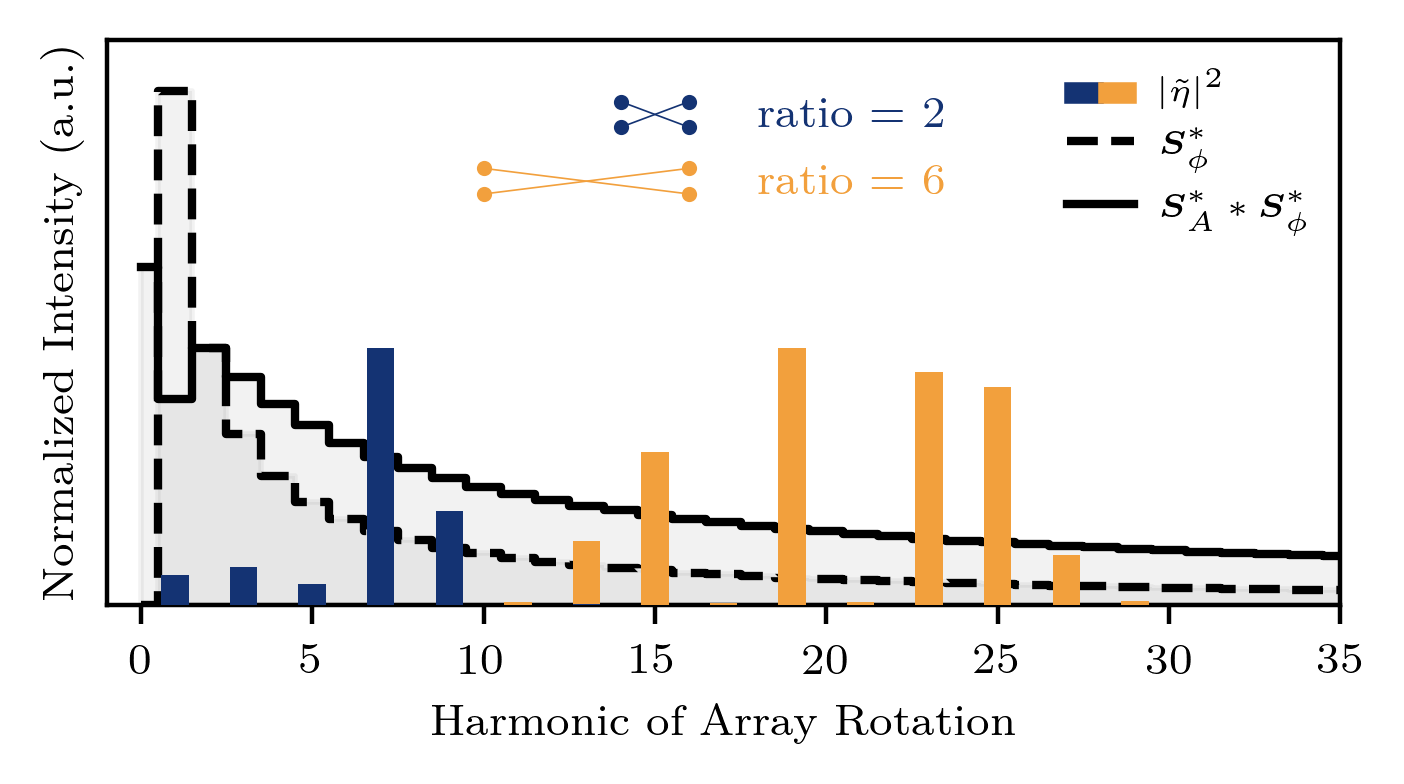

In [23]:
temp_scale = 0.5
maxn = 50

# extract one single color from thermal colormap
cs = {'k': 'k',
      'orange': '#d95f02',
      'green': '#7570b3', # '#1b9e77',
      'blue': '#7570b3'}

cs = {'k': 'k',
      'orange': '#F2A03D',
      'green': '#143373', # '#1b9e77',
      'blue': '#7570b3'}

fig, ax = plt.subplots(figsize=(3.55, 2), dpi=400)

plt.step(np.arange(maxn), np.abs(fftshift(d_a_psd[0][:-1]))[:maxn] / np.max(np.abs(fftshift(d_a_psd[0]))[:maxn]), c='k', ls='--', where='mid', label=r'$\boldsymbol{S}_\phi^*$')

plt.fill_between(np.arange(maxn), np.abs(fftshift(d_a_psd[0][:-1]))[:maxn] / np.max(np.abs(fftshift(d_a_psd[0]))[:maxn]), step='mid', alpha=0.1, color='gray')

plt.step(np.arange(maxn), 
         np.abs(fftshift(conv_psd[:-1]))[:maxn] / np.max(np.abs(fftshift(conv_psd))[:maxn]) / 2,
         c='k', ls='-', where='mid', label=r'$\boldsymbol{S}_A^* \ast \boldsymbol{S}_\phi^*$')

plt.fill_between(np.arange(maxn), 
         np.abs(fftshift(conv_psd[:-1]))[:maxn] / np.max(np.abs(fftshift(conv_psd))[:maxn]) / 2,
                 step='mid',
                 alpha=0.1, color='gray')

plt.bar(np.arange(maxn), np.abs(fftshift(template_ft[:-1]**2))[:maxn] / np.max(np.abs(fftshift(template_ft[:-1]**2))[:maxn]) * temp_scale, color=cs['orange'], zorder=10, alpha=1)

plt.bar(np.arange(maxn), np.abs(fftshift(template_ft_2[:-1]**2))[:maxn] / np.max(np.abs(fftshift(template_ft_2[:-1]**2))[:maxn]) * temp_scale, color=cs['green'], zorder=10, alpha=1)

plt.xlim(-1, 35)
plt.ylim(0, 1.1)

plt.yticks([])
plt.xlabel('Harmonic of Array Rotation')
plt.ylabel('Normalized Intensity (a.u.)')

# Create a custom two-colored patch (half orange, half blue)
custom_patch = Rectangle((0, 0), 1, 1, color='none',
                         edgecolor='none')  # An invisible rectangle to hold the legend space

# Custom legend handler class to create a two-colored bar
class TwoColorPatchHandler(HandlerBase):
    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        # Create two rectangles for the two colors
        
        height *= 0.7
        
        orange_patch = Rectangle([x0, y0], width / 2, height, transform=trans, color=cs['green'])
        blue_patch = Rectangle([x0 + width / 2, y0], width / 2, height, transform=trans, color=cs['orange'])
        
        return [orange_patch, blue_patch]

# Get the existing handles and labels for the sine and cosine plots
handles, labels = ax.get_legend_handles_labels()

# Append the custom patch to the handles and the corresponding label
handles.insert(0, custom_patch)
labels.insert(0, r'$| \tilde{\eta} |^2$')

# Add the custom patch and the existing entries to the legend
legend = ax.legend(handles=handles, labels=labels, handler_map={custom_patch: TwoColorPatchHandler()}, frameon=False, loc='upper right', fontsize=6)


x_2 = [16, 0.98]
b_2 = 0.05

pos_2 = np.array([x_2, 
         [x_2[0], x_2[1] - b_2],
         [x_2[0] - b_2*2*20, x_2[1] - b_2], 
         [x_2[0] - b_2*2*20, x_2[1]]])

x_6 = [16, 0.85]
b_6 = 0.05

pos_6 = np.array([x_6,
         [x_6[0], x_6[1] - b_6],
         [x_6[0] - b_6*6*20, x_6[1] - b_6], 
         [x_6[0] - b_6*6*20, x_6[1]]])

ax.scatter(pos_2[:, 0], pos_2[:, 1], s=3, c=cs['green'])
ax.scatter(pos_6[:, 0], pos_6[:, 1], c=cs['orange'], s=3)

ax.text(18, 0.95, 'ratio = 2', ha='left', va='center', fontsize=8, color=cs['green'])
ax.text(18, 0.82, 'ratio = 6', ha='left', va='center', fontsize=8, color=cs['orange'])

plt.plot([pos_2[0, 0], pos_2[2, 0]], [pos_2[0, 1], pos_2[2, 1]], c=cs['green'], lw=0.3)
plt.plot([pos_2[1, 0], pos_2[3, 0]], [pos_2[1, 1], pos_2[3, 1]], c=cs['green'], lw=0.3)

plt.plot([pos_6[0, 0], pos_6[2, 0]], [pos_6[0, 1], pos_6[2, 1]], c=cs['orange'], lw=0.3)
plt.plot([pos_6[1, 0], pos_6[3, 0]], [pos_6[1, 1], pos_6[3, 1]], c=cs['orange'], lw=0.3)

plt.tight_layout()
plt.show()